## 1. Setup and Imports

In [1]:
# Install required packages (uncomment if needed)
# !pip install pandas numpy nltk matplotlib seaborn scikit-learn tensorflow keras imbalanced-learn wordcloud

In [3]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import joblib
from datetime import datetime

# NLP
import nltk
from wordcloud import WordCloud

# Deep Learning
from keras import layers, optimizers, losses, callbacks, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             classification_report, roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Download NLTK resources
nltk.download('stopwords', quiet=True)

print("✓ All imports successful!")

✓ All imports successful!


## 2. Configuration

In [4]:
CONFIG = {
    'random_state': 113,
    'test_size': 0.2,
    'val_split': 0.5,
    'max_features': 20000,
    'ngram_range': (1, 2),  # Include bigrams
    'max_epochs': 128,
    'batch_size': 32,
    'early_stopping_patience': 5,
    'learning_rate': 0.0001,
    'lstm_max_length': 100,
    'lstm_vocab_size': 10000
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  random_state: 113
  test_size: 0.2
  val_split: 0.5
  max_features: 20000
  ngram_range: (1, 2)
  max_epochs: 128
  batch_size: 32
  early_stopping_patience: 5
  learning_rate: 0.0001
  lstm_max_length: 100
  lstm_vocab_size: 10000


## 3. Text Preprocessing Functions

In [5]:
def removeHTML(sentence):
    """Remove HTML tags from text"""
    regex = re.compile('<.*?>')
    return re.sub(regex, ' ', sentence)

def removeURL(sentence):
    """Remove URLs from text"""
    regex = re.compile('http[s]?://\S+')
    return re.sub(regex, ' ', sentence)

def onlyAlphabets(sentence):
    """Keep only alphabetic characters"""
    regex = re.compile('[^a-zA-Z]')
    return re.sub(regex, ' ', sentence)

def removeRecurring(sentence):
    """Reduce recurring characters (e.g., 'hellooo' -> 'hello')"""
    return re.sub(r'(.)\1{2,}', r'\1', sentence)

print("✓ Text cleaning functions defined")

✓ Text cleaning functions defined


In [6]:
def extract_metadata_features(text):
    """
    Extract metadata features from text
    Returns dictionary of features
    """
    return {
        'length': len(text),
        'num_words': len(text.split()),
        'num_digits': sum(c.isdigit() for c in text),
        'num_uppercase': sum(c.isupper() for c in text),
        'num_special': len(re.findall(r'[!@#$%^&*()]', text)),
        'num_urls': len(re.findall(r'http[s]?://\S+', text)),
        'has_money_symbol': int('$' in text or '£' in text or '€' in text),
        'num_exclamation': text.count('!'),
        'num_question': text.count('?'),
        'uppercase_ratio': sum(c.isupper() for c in text) / (len(text) + 1),
        'digit_ratio': sum(c.isdigit() for c in text) / (len(text) + 1),
        'avg_word_length': np.mean([len(word) for word in text.split()]) if text.split() else 0
    }

print("✓ Feature extraction function defined")

✓ Feature extraction function defined


In [7]:
def clean_text(df, stop_words=None):
    """
    Comprehensive text cleaning pipeline
    """
    sno = nltk.stem.SnowballStemmer('english')
    spam_words = []
    ham_words = []
    all_sentences = []

    print("Cleaning text data...")
    for idx, row in df.iterrows():
        review = row['Message']
        rating = row['Category']

        cleaned_sentence = []

        # Apply cleaning functions
        sentence = removeURL(review)
        sentence = removeHTML(sentence)
        sentence = onlyAlphabets(sentence)
        sentence = sentence.lower()
        sentence = removeRecurring(sentence)

        # Stemming
        for word in sentence.split():
            if stop_words is None or word not in stop_words:
                stemmed = sno.stem(word)
                cleaned_sentence.append(stemmed)

                if rating == 1:
                    spam_words.append(stemmed)
                else:
                    ham_words.append(stemmed)

        all_sentences.append(' '.join(cleaned_sentence))

    df['Cleaned'] = all_sentences

    return df, spam_words, ham_words

print("✓ Text cleaning pipeline defined")

✓ Text cleaning pipeline defined


## 4. Visualization Functions

In [8]:
def plot_word_clouds(spam_words, ham_words):
    """Generate word clouds for spam and ham messages"""
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Spam word cloud
    axes[0].imshow(WordCloud(width=800, height=400,
                             background_color='white').generate(' '.join(spam_words)))
    axes[0].set_title('Spam Messages Word Cloud', fontsize=20, fontweight='bold')
    axes[0].axis('off')

    # Ham word cloud
    axes[1].imshow(WordCloud(width=800, height=400,
                             background_color='white').generate(' '.join(ham_words)))
    axes[1].set_title('Ham Messages Word Cloud', fontsize=20, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def plot_class_distribution(df):
    """Plot distribution of spam vs ham messages"""
    plt.figure(figsize=(8, 6))
    counts = df['Category'].value_counts()
    plt.bar(['Ham', 'Spam'], counts.values, color=['green', 'red'], alpha=0.7)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Distribution of Messages', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    total = counts.sum()
    for i, v in enumerate(counts.values):
        plt.text(i, v + 10, f'{v}\n({v/total*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    """Plot normalized confusion matrix"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return cm, cm_normalized

def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve'):
    """Plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return roc_auc

def plot_training_history(history, metric1='accuracy', metric2='val_accuracy'):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    axes[0].plot(history[metric1], label='Training', linewidth=2)
    axes[0].plot(history[metric2], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(alpha=0.3)

    # Loss plot
    axes[1].plot(history['loss'], label='Training', linewidth=2)
    axes[1].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

print("✓ Visualization functions defined")

✓ Visualization functions defined


## 5. Model Building Functions

In [9]:
def build_dense_model(input_shape, config):
    """Build dense neural network"""
    model = models.Sequential([
        layers.Dense(16, activation='relu', input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(config['learning_rate']),
        loss=losses.BinaryCrossentropy(),
        metrics=['accuracy', 'AUC']
    )

    return model

def build_lstm_model(config):
    """Build LSTM model for sequence classification"""
    model = models.Sequential([
        layers.Embedding(config['lstm_vocab_size'], 128,
                        input_length=config['lstm_max_length']),
        layers.SpatialDropout1D(0.2),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(config['learning_rate']),
        loss=losses.BinaryCrossentropy(),
        metrics=['accuracy', 'AUC']
    )

    return model

print("✓ Model building functions defined")

✓ Model building functions defined


In [10]:
def train_traditional_models(X_train, y_train, X_test, y_test):
    """Train multiple traditional ML models"""
    models_dict = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=CONFIG['random_state']),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=CONFIG['random_state']),
        'Gradient Boosting': GradientBoostingClassifier(random_state=CONFIG['random_state'])
    }

    results = {}
    trained_models = {}

    print("\nTraining traditional ML models...")
    for name, model in models_dict.items():
        print(f"  Training {name}...")
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else pred

        results[name] = {
            'Accuracy': accuracy_score(y_test, pred),
            'F1 Score': f1_score(y_test, pred),
            'ROC-AUC': roc_auc_score(y_test, pred_proba)
        }
        trained_models[name] = model

    # Display results
    results_df = pd.DataFrame(results).T
    print("\n" + "="*60)
    print("Traditional ML Models Performance")
    print("="*60)
    print(results_df.to_string())
    print("="*60 + "\n")

    return trained_models, results_df

print("✓ Traditional model training function defined")

✓ Traditional model training function defined


## 6. Evaluation Functions

In [11]:
def comprehensive_evaluation(model, X_test, y_test, model_name='Model'):
    """Perform comprehensive model evaluation"""
    print(f"\n{'='*60}")
    print(f"{model_name} - Comprehensive Evaluation")
    print('='*60)

    # Predictions
    y_pred_proba = model.predict(X_test)
    if len(y_pred_proba.shape) > 1:
        y_pred_proba = y_pred_proba[:, 0]
    y_pred = (y_pred_proba > 0.5).astype('int')

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\nKey Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print('='*60 + '\n')

    return y_pred, y_pred_proba

print("✓ Evaluation function defined")

✓ Evaluation function defined


## 7. Prediction Function

In [12]:
def predict_spam(message, model, cv, tfidf):
    """
    Predict if a message is spam or ham
    """
    sno = nltk.stem.SnowballStemmer('english')

    # Clean text
    cleaned = removeURL(message)
    cleaned = removeHTML(cleaned)
    cleaned = onlyAlphabets(cleaned)
    cleaned = cleaned.lower()
    cleaned = removeRecurring(cleaned)

    # Stem
    stemmed_words = [sno.stem(word) for word in cleaned.split()]
    cleaned_text = ' '.join(stemmed_words)

    # Transform
    vec = cv.transform([cleaned_text])
    tfidf_vec = tfidf.transform(vec)

    # Predict
    prob = model.predict(tfidf_vec.toarray())[0][0]
    label = 'spam' if prob > 0.5 else 'ham'
    confidence = prob if label == 'spam' else 1 - prob

    return {
        'original_message': message,
        'cleaned_text': cleaned_text,
        'label': label,
        'confidence': confidence,
        'spam_probability': prob
    }

print("✓ Prediction function defined")

✓ Prediction function defined


---
# Main Pipeline
---

## 8. Load Data

In [13]:
# Mount Google Drive (if using Colab)
# from google.colab import drive
# drive.mount('/content/drive')

# Load data - UPDATE THIS PATH
DATA_PATH = '/content/TEXT (3).csv'  # Change this to your file path

df = pd.read_csv(DATA_PATH)

print(f"✓ Loaded {len(df)} messages")
print(f"\nColumns: {list(df.columns)}")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()

✓ Loaded 5572 messages

Columns: ['Category', 'Message']
Shape: (5572, 2)

First few rows:


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 9. Exploratory Data Analysis

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Category Distribution:
Category
ham     4825
spam     747
Name: count, dtype: int64


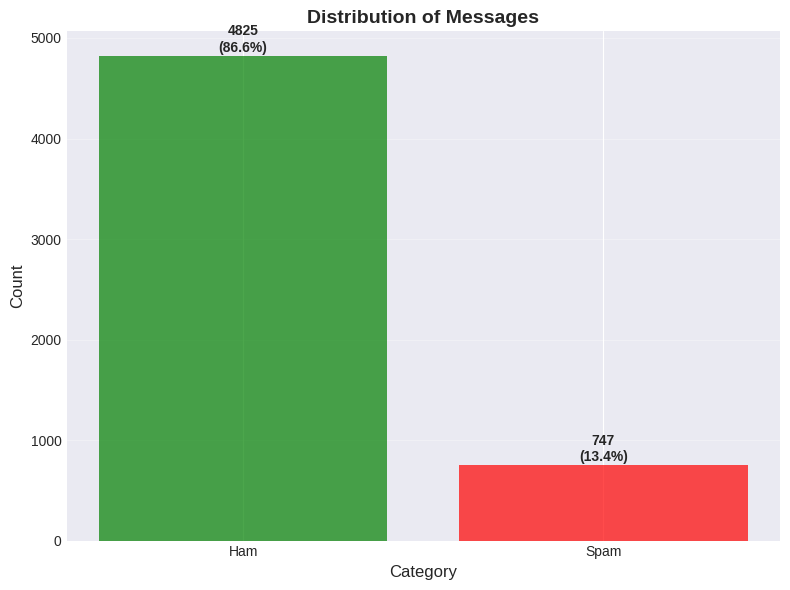

In [14]:
# Display basic info
print("Dataset Info:")
df.info()

print("\nCategory Distribution:")
print(df['Category'].value_counts())

# Plot distribution
plot_class_distribution(df)

## 10. Data Cleaning

In [15]:
# Remove duplicates
initial_len = len(df)
df = df.drop_duplicates()
print(f"Removed {initial_len - len(df)} duplicates")

# Encode labels
df['Category'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)
print(f"\nSpam messages: {df['Category'].sum()}")
print(f"Ham messages: {len(df) - df['Category'].sum()}")

Removed 415 duplicates

Spam messages: 641
Ham messages: 4516


In [16]:
# Extract metadata features
print("Extracting metadata features...")
metadata_df = df['Message'].apply(extract_metadata_features).apply(pd.Series)

print("\nMetadata features:")
metadata_df.head()

Extracting metadata features...

Metadata features:


,length,num_words,num_digits,num_uppercase,num_special,num_urls,has_money_symbol,num_exclamation,num_question,uppercase_ratio,digit_ratio,avg_word_length
0,111.0,20.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.026786,0.000000,4.600000
1,29.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.000000,4.000000
2,155.0,28.0,25.0,10.0,3.0,0.0,0.0,0.0,0.0,0.064103,0.160256,4.571429
3,49.0,11.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.000000,3.545455
4,61.0,13.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.000000,3.769231


In [17]:
# Clean text
stop_words = set(nltk.corpus.stopwords.words('english'))
df, spam_words, ham_words = clean_text(df, stop_words=None)

print(f"\n✓ Text cleaning complete")
print(f"Total spam words: {len(spam_words)}")
print(f"Total ham words: {len(ham_words)}")

Cleaning text data...

✓ Text cleaning complete
Total spam words: 14497
Total ham words: 65421


## 11. Visualizations

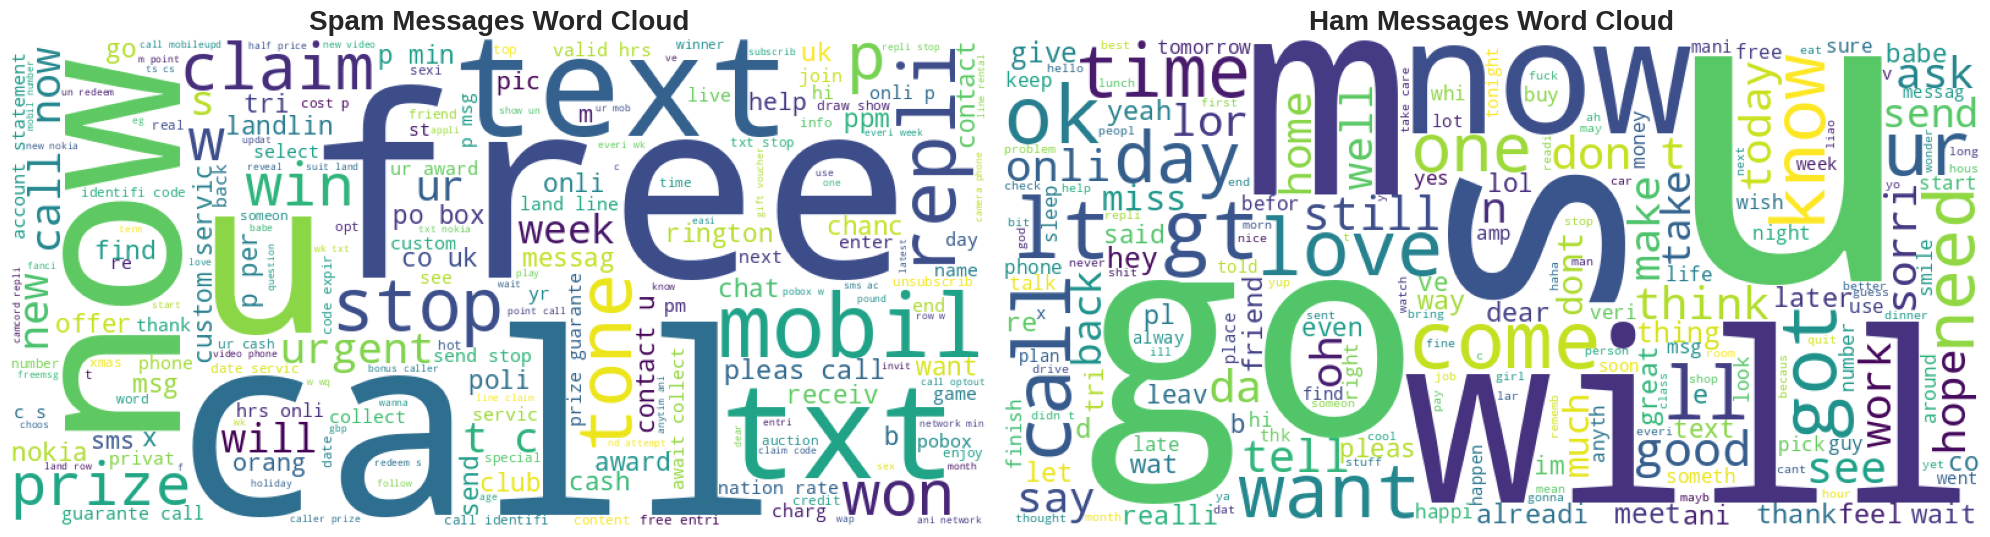

In [18]:
# Generate word clouds
plot_word_clouds(spam_words, ham_words)

## 12. Train-Test Split

In [19]:
# Split data
train_df, val_test_df = train_test_split(
    df, test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=df['Category']
)

val_df, test_df = train_test_split(
    val_test_df, test_size=CONFIG['val_split'],
    random_state=CONFIG['random_state'],
    stratify=val_test_df['Category']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 4125
Validation samples: 516
Testing samples: 516


## 13. Feature Extraction (TF-IDF)

In [20]:
# Bag of Words
cv = CountVectorizer(
    ngram_range=CONFIG['ngram_range'],
    max_features=CONFIG['max_features']
)

train_bow = cv.fit_transform(train_df['Cleaned'])
val_bow = cv.transform(val_df['Cleaned'])
test_bow = cv.transform(test_df['Cleaned'])

print(f"Vocabulary size: {len(cv.get_feature_names_out())}")

# TF-IDF
tfidf = TfidfTransformer().fit(train_bow)
train_tf = tfidf.transform(train_bow)
val_tf = tfidf.transform(val_bow)
test_tf = tfidf.transform(test_bow)

print(f"Feature matrix shape: {train_tf.shape}")

# Prepare arrays
X_train = train_tf.toarray()
y_train = train_df['Category'].values
X_val = val_tf.toarray()
y_val = val_df['Category'].values
X_test = test_tf.toarray()
y_test = test_df['Category'].values

print("\n✓ Feature extraction complete")

Vocabulary size: 20000
Feature matrix shape: (4125, 20000)

✓ Feature extraction complete


## 14. Handle Class Imbalance (Optional)

In [21]:
# Set to True to use SMOTE
use_smote = False

if use_smote:
    print("Applying SMOTE...")
    smote = SMOTE(random_state=CONFIG['random_state'])
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"Resampled training samples: {len(X_train)}")
    print(f"Spam: {y_train.sum()}, Ham: {len(y_train) - y_train.sum()}")
else:
    print("Not using SMOTE")

Not using SMOTE


## 15. Train Traditional ML Models

In [22]:
traditional_models, trad_results = train_traditional_models(
    X_train, y_train, X_test, y_test
)

# Display results as DataFrame
trad_results


Training traditional ML models...
  Training Naive Bayes...
  Training Logistic Regression...
  Training Random Forest...
  Training Gradient Boosting...

Traditional ML Models Performance
                     Accuracy  F1 Score   ROC-AUC
Naive Bayes          0.943798  0.707071  0.973693
Logistic Regression  0.957364  0.792453  0.996025
Random Forest        0.965116  0.836364  0.995973
Gradient Boosting    0.955426  0.788991  0.984116



,Accuracy,F1 Score,ROC-AUC
Naive Bayes,0.943798,0.707071,0.973693
Logistic Regression,0.957364,0.792453,0.996025
Random Forest,0.965116,0.836364,0.995973
Gradient Boosting,0.955426,0.788991,0.984116


## 16. Build and Train Neural Network

In [23]:
# Build model
nn_model = build_dense_model((X_train.shape[1],), CONFIG)
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │       320,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,193 (1.22 MB)

 Trainable params: 320,193 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Callbacks
early_stop = callbacks.EarlyStopping(
    patience=CONFIG['early_stopping_patience'],
    restore_best_weights=True,
    monitor='val_loss'
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

# Train
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=CONFIG['max_epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/128
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - AUC: 0.5049 - accuracy: 0.6576 - loss: 0.6926 - val_AUC: 0.5234 - val_accuracy: 0.8760 - val_loss: 0.6884 - learning_rate: 1.0000e-04
Epoch 2/128
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.5228 - accuracy: 0.8728 - loss: 0.6873 - val_AUC: 0.5000 - val_accuracy: 0.8760 - val_loss: 0.6837 - learning_rate: 1.0000e-04
Epoch 3/128
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.5238 - accuracy: 0.8726 - loss: 0.6826 - val_AUC: 0.5469 - val_accuracy: 0.8760 - val_loss: 0.6789 - learning_rate: 1.0000e-04
Epoch 4/128
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - AUC: 0.5734 - accuracy: 0.8777 - loss: 0.6777 - val_AUC: 0.7742 - val_accuracy: 0.8760 - val_loss: 0.6739 - learning_rate: 1.0000e-04
Epoch 5/128
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.7894 - accuracy: 0.8898 - loss: 0.6722 - val_AUC: 0.8572 - val_accuracy: 0.8992 - val_loss: 0.6679 - learning_rate: 1.0000e-04
Epoch 6/128
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/s

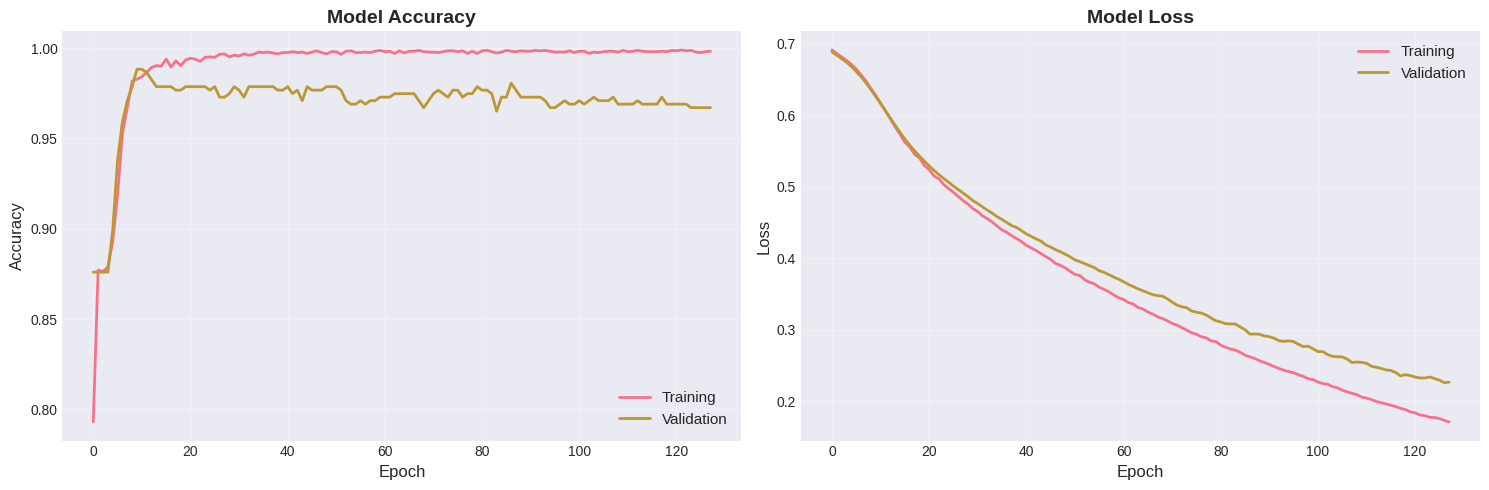

In [25]:
# Plot training history
plot_training_history(history.history)

## 17. Evaluate Neural Network

In [26]:
# Comprehensive evaluation
y_pred, y_pred_proba = comprehensive_evaluation(
    nn_model, X_test, y_test,
    model_name='Neural Network'
)


Neural Network - Comprehensive Evaluation
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      0.96      0.98       452
        Spam       0.78      0.97      0.87        64

    accuracy                           0.96       516
   macro avg       0.89      0.97      0.92       516
weighted avg       0.97      0.96      0.96       516


Key Metrics:
  Accuracy:  0.9632
  F1 Score:  0.8671
  ROC-AUC:   0.9906



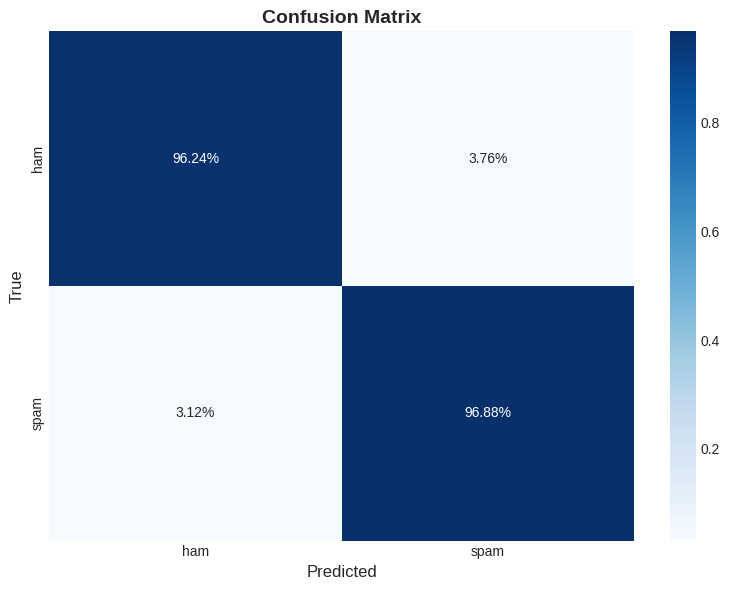

In [27]:
# Confusion Matrix
y_test_labels = ['spam' if i == 1 else 'ham' for i in y_test]
y_pred_labels = ['spam' if i == 1 else 'ham' for i in y_pred]
cm, cm_norm = plot_confusion_matrix(y_test_labels, y_pred_labels, ['ham', 'spam'])

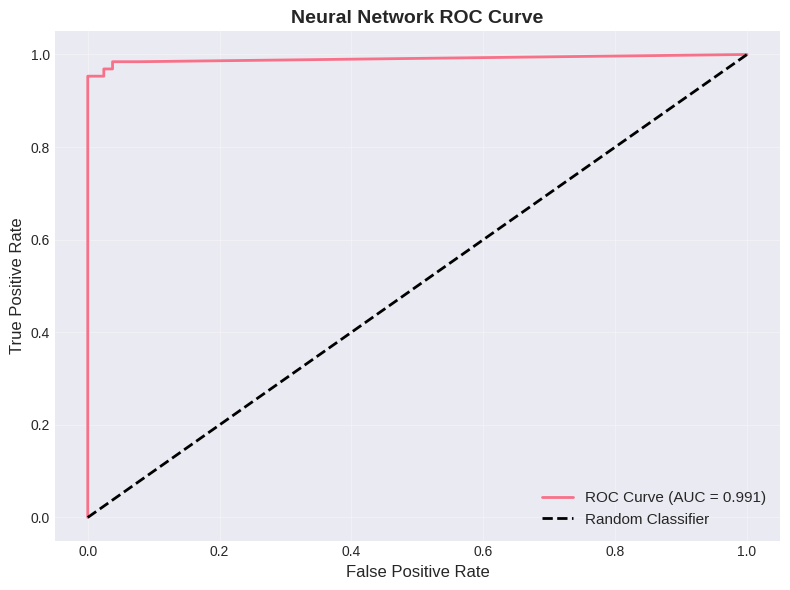

ROC-AUC Score: 0.9906


In [28]:
# ROC Curve
roc_auc = plot_roc_curve(y_test, y_pred_proba, title='Neural Network ROC Curve')
print(f"ROC-AUC Score: {roc_auc:.4f}")

## 18. Cross-Validation

In [29]:
# Cross-validation with best traditional model
best_trad_model = traditional_models['Gradient Boosting']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CONFIG['random_state'])
cv_scores = cross_val_score(best_trad_model, X_train, y_train,
                            cv=skf, scoring='f1')

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Cross-validation F1 scores: [0.86813187 0.81521739 0.89583333 0.86956522 0.81142857]
Mean F1: 0.8520 (+/- 0.0331)


## 19. Save Models

In [30]:
# Save neural network
nn_model.save('spam_classifier_nn.h5')
print("✓ Saved: spam_classifier_nn.h5")

# Save complete pipeline
pipeline_data = {
    'vectorizer': cv,
    'tfidf': tfidf,
    'config': CONFIG,
    'feature_names': cv.get_feature_names_out()
}
joblib.dump(pipeline_data, 'spam_classifier_pipeline.pkl')
print("✓ Saved: spam_classifier_pipeline.pkl")

# Save best traditional model
joblib.dump(traditional_models['Gradient Boosting'], 'spam_classifier_gb.pkl')
print("✓ Saved: spam_classifier_gb.pkl")

✓ Saved: spam_classifier_nn.h5
✓ Saved: spam_classifier_pipeline.pkl
✓ Saved: spam_classifier_gb.pkl


## 20. Demo Predictions

In [31]:
# Test predictions on demo messages
demo_messages = [
    "Congratulations! You've won a $1000 gift card. Click here to claim now!",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your account has been suspended. Verify your identity immediately.",
    "Can you send me the notes from yesterday's meeting?",
    "FREE! Call now to win amazing prizes!!!",
    "Mom, I'll be home late tonight. Don't wait for dinner."
]

print("="*70)
print("DEMO PREDICTIONS")
print("="*70)

for i, msg in enumerate(demo_messages, 1):
    result = predict_spam(msg, nn_model, cv, tfidf)
    print(f"\n{i}. Message: {msg}")
    print(f"   Prediction: {result['label'].upper()}")
    print(f"   Confidence: {result['confidence']:.2%}")
    print(f"   Spam Probability: {result['spam_probability']:.4f}")

print("\n" + "="*70)

DEMO PREDICTIONS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1. Message: Congratulations! You've won a $1000 gift card. Click here to claim now!
   Prediction: SPAM
   Confidence: 100.00%
   Spam Probability: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

2. Message: Hey, are we still meeting for lunch tomorrow?
   Prediction: HAM
   Confidence: 82.48%
   Spam Probability: 0.1752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

3. Message: URGENT: Your account has been suspended. Verify your identity immediately.
   Prediction: SPAM
   Confidence: 100.00%
   Spam Probability: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

4. Message: Can you send me the notes from yesterday's meeting?
   Prediction: HAM
   Confidence: 82.48%
   Spam Probability: 0.1752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

5. Message: FREE! Call now to win amazing prizes!!!
   Prediction: SPAM
   Confidence: 100.00%
   Spam Probability: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

6. Message: Mom, I'll be home late tonight. Don't wai

## 21. Interactive Prediction

In [32]:
# Try your own message!
your_message = "Enter your message here"

result = predict_spam(your_message, nn_model, cv, tfidf)

print("="*70)
print(f"Message: {result['original_message']}")
print(f"\nCleaned: {result['cleaned_text']}")
print(f"\nPrediction: {result['label'].upper()}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Spam Probability: {result['spam_probability']:.4f}")
print("="*70)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Message: Enter your message here

Cleaned: enter your messag here

Prediction: SPAM
Confidence: 97.37%
Spam Probability: 0.9737


Summary

This notebook implemented a comprehensive spam classification system with:

**Data Preprocessing**: Text cleaning, stemming, feature extraction  
**Multiple Models**: Neural Network + 4 traditional ML models  
**Feature Engineering**: TF-IDF + metadata features  
**Comprehensive Evaluation**: Accuracy, F1, ROC-AUC, confusion matrix  
**Visualization**: Word clouds, training curves, ROC curves  
**Model Persistence**: Save and load trained models  
**Prediction Pipeline**: Ready for deployment  

---